In [56]:
import pandas as pd
import numpy as np
import datetime as dt

dam_excel = "/Users/shynmere/Desktop/ercot_project/dam25.xlsx"
rtm_excel = "/Users/shynmere/Desktop/ercot_project/rtm25.xlsx"

P_MAX = 1      
E_MAX = 2      
RTE = 0.85     
HUB = "HB_HOUSTON"  

In [57]:
# DAY AHEAD MARKET

def dam_tau_greedy_day(prices):

    prices = np.array(prices)
    best_rev = 0
    best_tau = None

    for tau in range(1, 24):
        
        buy_hours  = np.arange(0, tau)   
        sell_hours = np.arange(tau, 24)   

        buy_sorted  = buy_hours[np.argsort(prices[buy_hours])]
        sell_sorted = sell_hours[np.argsort(-prices[sell_hours])]

        energy_used = 0
        revenue = 0

        for b, s in zip(buy_sorted, sell_sorted):

            if energy_used >= E_MAX:
                break

            spread = prices[s] * RTE - prices[b]
            if spread <= 0:
                break

            revenue += spread
            energy_used += 1

        if revenue > best_rev:
            best_rev = revenue
            best_tau = tau

    return best_rev, best_tau

def dam_load_and_clean_month(excel_path, sheet_name, hub=HUB):
 
    df = pd.read_excel(excel_path, sheet_name=sheet_name)
    df = df[df['Settlement Point'] == hub]

    df['Delivery Date'] = pd.to_datetime(df['Delivery Date'])
    df['hour'] = df['Hour Ending'].str.split(':').str[0].astype(int)
    df['timestamp'] = df['Delivery Date'] + pd.to_timedelta(df['hour'], unit='h')

    df = df[['timestamp', 'Settlement Point Price']]
    df = df.rename(columns={'Settlement Point Price': 'price'})
    df = df.reset_index()

    df['date'] = df['timestamp'].dt.date
    df['hour'] = df['timestamp'].dt.hour

    mask = (df['hour'] == 0) & (df['index'] > 0)
    df.loc[mask, 'hour'] = 24
    df.loc[mask, 'date'] = df['date'].shift(1)

    days = sorted(df['date'].unique())
    daily_arrays = []
    clean_days = []

    for d in days:
        day_df = df[df['date'] == d].sort_values('hour')
        prices = day_df['price'].values

        if len(prices) != 24:
            print(f"Skipping {d}: {len(prices)} hours found")
            continue

        daily_arrays.append(prices)
        clean_days.append(d)

    return clean_days, daily_arrays

def dam_process_month(sheet_name, excel_path, hub=HUB):

    days, daily_arrays = dam_load_and_clean_month(excel_path, sheet_name, hub)

    results = []
    for i, arr in enumerate(daily_arrays):
        rev, tau = dam_tau_greedy_day(arr)
        results.append({
            'date': days[i],
            'dam_revenue': rev,
            'dam_tau': tau,
            'month': sheet_name
        })

    return pd.DataFrame(results)

def dam_run_all_months(excel_path, hub=HUB):

    months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
              "Jul", "Aug", "Sep", "Oct", "Nov"]

    dam_results = []

    for m in months:
        print(f"Processing DAM {m}...")
        monthly_df = dam_process_month(m, excel_path, hub)
        dam_results.append(monthly_df)

    full_df = pd.concat(dam_results).reset_index(drop=True)
    return full_df

dam_full = dam_run_all_months(dam_excel)
dam_full


Processing DAM Jan...
Processing DAM Feb...
Processing DAM Mar...
Skipping 2025-03-09: 23 hours found
Processing DAM Apr...
Processing DAM May...
Processing DAM Jun...
Processing DAM Jul...
Processing DAM Aug...
Processing DAM Sep...
Processing DAM Oct...
Processing DAM Nov...
Skipping 2025-11-02: 25 hours found


,date,dam_revenue,dam_tau,month
0,2025-01-01,30.0780,16,Jan
1,2025-01-02,28.0710,4,Jan
2,2025-01-03,20.9065,16,Jan
3,2025-01-04,14.7855,14,Jan
4,2025-01-05,39.0105,4,Jan
...,...,...,...,...
327,2025-11-26,81.7205,15,Nov
328,2025-11-27,45.7710,16,Nov
329,2025-11-28,34.2445,14,Nov
330,2025-11-29,25.1545,3,Nov


In [58]:
# REAL TIME MARKET

STEP_HOURS = 15 / 60 
STEP_MWH   = P_MAX * STEP_HOURS 

def rtm_tau_greedy_day(prices):

    prices = np.array(prices)
    n = len(prices)

    best_rev = 0
    best_tau = None

    for tau in range(1, n):
        buy_hours  = np.arange(0, tau)
        sell_hours = np.arange(tau, n)

        buy_sorted  = buy_hours[np.argsort(prices[buy_hours])]
        sell_sorted = sell_hours[np.argsort(-prices[sell_hours])]

        energy_used = 0
        revenue = 0

        for b, s in zip(buy_sorted, sell_sorted):
            if energy_used + STEP_MWH > E_MAX:
                break

            spread = prices[s] * RTE - prices[b]
            if spread <= 0:
                break

            revenue += spread * STEP_MWH 
            energy_used += STEP_MWH

        if revenue > best_rev:
            best_rev = revenue
            best_tau = tau

    return best_rev, best_tau


def rtm_load_and_clean_month(excel_path, sheet_name, hub="HB_HOUSTON"):

    df = pd.read_excel(excel_path, sheet_name=sheet_name)
    df = df[df['Settlement Point Name'] == hub].copy()

    df['Delivery Date'] = pd.to_datetime(df['Delivery Date'])
    df['minute'] = (df['Delivery Hour'] - 1) * 60 + (df['Delivery Interval'] - 1) * 15
    df['timestamp'] = df['Delivery Date'] + pd.to_timedelta(df['minute'], unit='m')

    df = df[['timestamp', 'Settlement Point Price']]
    df = df.rename(columns={'Settlement Point Price': 'price'})

    df['date'] = df['timestamp'].dt.date

    days = sorted(df['date'].unique())
    daily_arrays = []
    clean_days = []

    for d in days:
        day_df = df[df['date'] == d].sort_values('timestamp')
        prices = day_df['price'].values

        if len(prices) != 96:
            print(f"Skipping {d} — has {len(prices)} intervals (expected 96)")
            continue

        daily_arrays.append(prices)
        clean_days.append(d)

    return clean_days, daily_arrays

def rtm_process_month(sheet_name, excel_path, hub=HUB):

    days, daily_arrays = rtm_load_and_clean_month(excel_path, sheet_name, hub)

    results = []
    for i, arr in enumerate(daily_arrays):
        rev, tau = rtm_tau_greedy_day(arr)
        results.append({
            'date': days[i],
            'rtm_revenue': rev,
            'rtm_tau': tau,
            'month': sheet_name
        })

    return pd.DataFrame(results)

def rtm_run_all_months(excel_path, hub=HUB):

    months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
              "Jul", "Aug", "Sep", "Oct", "Nov"]

    rtm_results = []

    for m in months:
        print(f"Processing RTM {m}...")
        monthly_df = rtm_process_month(m, excel_path, hub)
        rtm_results.append(monthly_df)

    full_df = pd.concat(rtm_results).reset_index(drop=True)
    return full_df

rtm_full = rtm_run_all_months(rtm_excel)
rtm_full


Processing RTM Jan...
Processing RTM Feb...
Processing RTM Mar...
Skipping 2025-03-09 — has 92 intervals (expected 96)
Processing RTM Apr...
Processing RTM May...
Processing RTM Jun...
Processing RTM Jul...
Processing RTM Aug...
Processing RTM Sep...
Processing RTM Oct...
Processing RTM Nov...
Skipping 2025-11-02 — has 100 intervals (expected 96)


,date,rtm_revenue,rtm_tau,month
0,2025-01-01,123.374250,64,Jan
1,2025-01-02,39.851625,37,Jan
2,2025-01-03,27.967875,65,Jan
3,2025-01-04,38.331375,64,Jan
4,2025-01-05,98.211375,23,Jan
...,...,...,...,...
327,2025-11-26,65.518875,40,Nov
328,2025-11-27,22.203000,65,Nov
329,2025-11-28,45.022375,54,Nov
330,2025-11-29,27.257125,59,Nov


In [59]:
# Merge DAM & RTM

merged = pd.merge(
    rtm_full[['date','month', 'rtm_revenue', 'rtm_tau']],
    dam_full[['date', 'dam_revenue', 'dam_tau']],
    on='date',
    how='inner'
)

merged['uplift'] = merged['rtm_revenue'] - merged['dam_revenue'] 
merged['date'] = pd.to_datetime(merged['date'])
merged = merged.sort_values('date').reset_index(drop=True)

merged.head()


,date,month,rtm_revenue,rtm_tau,dam_revenue,dam_tau,uplift
0,2025-01-01,Jan,123.374250,64,30.0780,16,93.296250
1,2025-01-02,Jan,39.851625,37,28.0710,4,11.780625
2,2025-01-03,Jan,27.967875,65,20.9065,16,7.061375
3,2025-01-04,Jan,38.331375,64,14.7855,14,23.545875
4,2025-01-05,Jan,98.211375,23,39.0105,4,59.200875


In [60]:
summary = pd.DataFrame({
    "Mean DAM": [merged['dam_revenue'].mean()],
    "Mean RTM": [merged['rtm_revenue'].mean()],
    "Mean Uplift (RTM – DAM)": [merged['uplift'].mean()],
    "% Days RTM > DAM": [(merged['uplift'] > 0).mean() * 100],
    "Volatility DAM (STD)": [merged['dam_revenue'].std()],
    "Volatility RTM (STD)": [merged['rtm_revenue'].std()],
    "Max DAM": [merged['dam_revenue'].max()],
    "Max RTM": [merged['rtm_revenue'].max()],
    "Min DAM": [merged['dam_revenue'].min()],
    "Min RTM": [merged['rtm_revenue'].min()]
}).T

summary


,0
Mean DAM,91.022877
Mean RTM,110.459157
Mean Uplift (RTM – DAM),19.436280
% Days RTM > DAM,53.012048
Volatility DAM (STD),98.839166
Volatility RTM (STD),143.015967
Max DAM,1143.082000
Max RTM,1667.053500
Min DAM,7.365500
Min RTM,0.132125


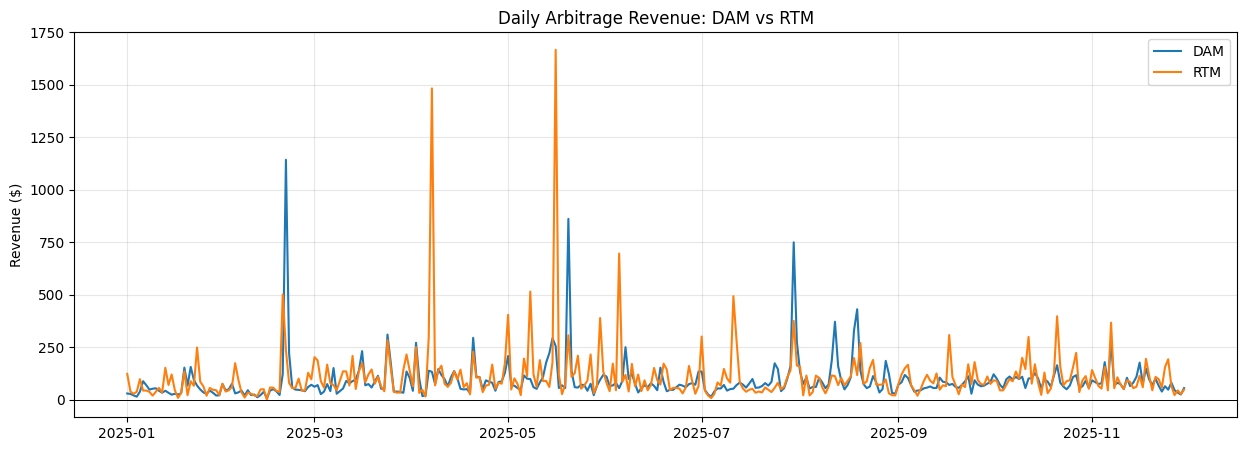

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(merged['date'], merged['dam_revenue'], label="DAM", lw=1.5)
plt.plot(merged['date'], merged['rtm_revenue'], label="RTM", lw=1.5)
plt.axhline(0, color='black', lw=0.7)

plt.title("Daily Arbitrage Revenue: DAM vs RTM")
plt.ylabel("Revenue ($)")
plt.legend()
plt.grid(alpha=0.3)

plt.show()



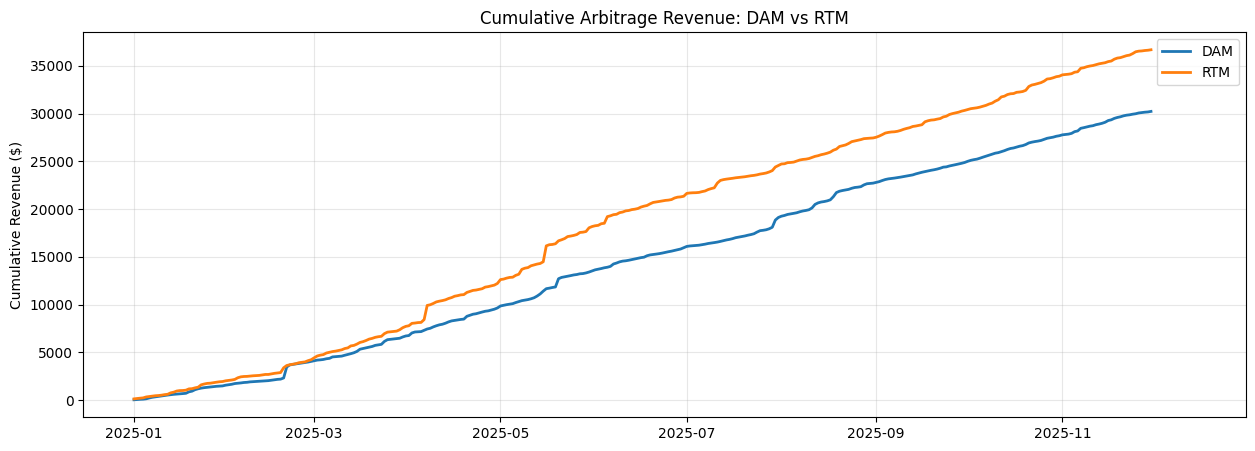

In [62]:
merged['date'] = pd.to_datetime(merged['date'])
merged = merged.sort_values('date')

merged['dam_cum'] = merged['dam_revenue'].cumsum()
merged['rtm_cum'] = merged['rtm_revenue'].cumsum()

plt.figure(figsize=(15,5))

plt.plot(
    merged['date'],
    merged['dam_cum'],
    label='DAM',
    lw=2,
)

plt.plot(
    merged['date'],
    merged['rtm_cum'],
    label='RTM',
    lw=2,
)

plt.title('Cumulative Arbitrage Revenue: DAM vs RTM')
plt.ylabel('Cumulative Revenue ($)')
plt.legend()
plt.grid(alpha=0.3)

ax = plt.gca()
left, _ = ax.get_xlim()
ax.set_xlim(left=left, right=pd.to_datetime('2025-12-31'))

plt.show()


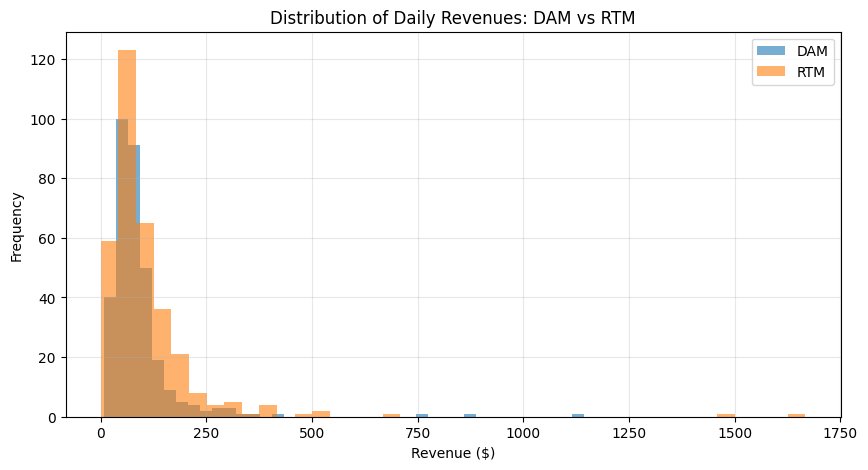

In [63]:
plt.figure(figsize=(10,5))
plt.hist(merged['dam_revenue'], bins=40, alpha=0.6, label="DAM")
plt.hist(merged['rtm_revenue'], bins=40, alpha=0.6, label="RTM")
plt.title("Distribution of Daily Revenues: DAM vs RTM")
plt.xlabel("Revenue ($)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


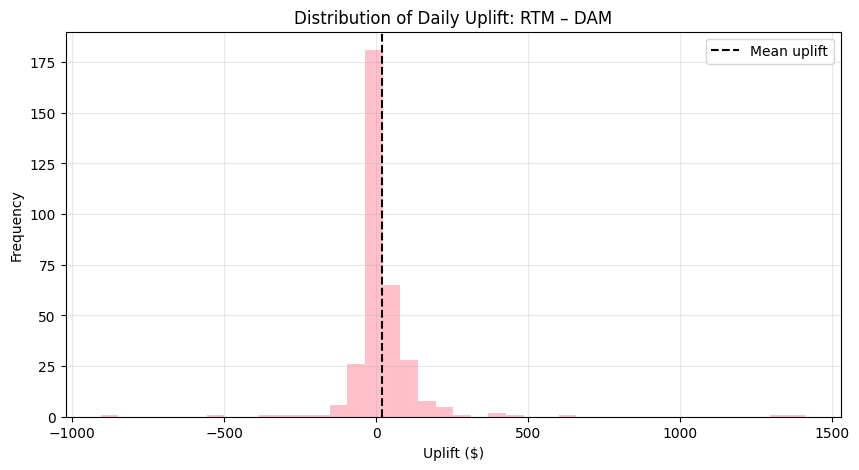

In [64]:
plt.figure(figsize=(10,5))
plt.hist(merged['uplift'], bins=40, color="pink")
plt.axvline(merged['uplift'].mean(), color='black', linestyle='--', label="Mean uplift")

plt.title("Distribution of Daily Uplift: RTM – DAM")
plt.xlabel("Uplift ($)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


<Figure size 1200x500 with 0 Axes>

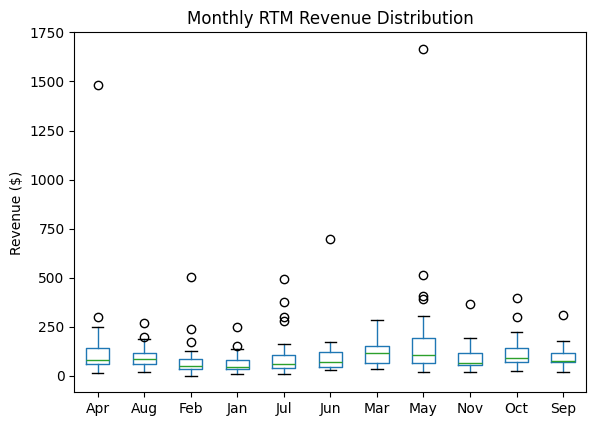

In [65]:
plt.figure(figsize=(12,5))
merged.boxplot(column='rtm_revenue', by='month', grid=False)
plt.title("Monthly RTM Revenue Distribution")
plt.suptitle("")
plt.ylabel("Revenue ($)")
plt.xlabel("")
plt.show()


<Figure size 1200x500 with 0 Axes>

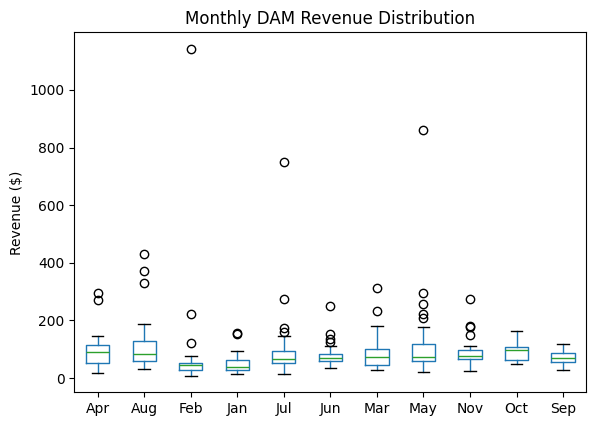

In [66]:
plt.figure(figsize=(12,5))
merged.boxplot(column='dam_revenue', by='month', grid=False)
plt.title("Monthly DAM Revenue Distribution")
plt.suptitle("")
plt.ylabel("Revenue ($)")
plt.xlabel("")
plt.show()


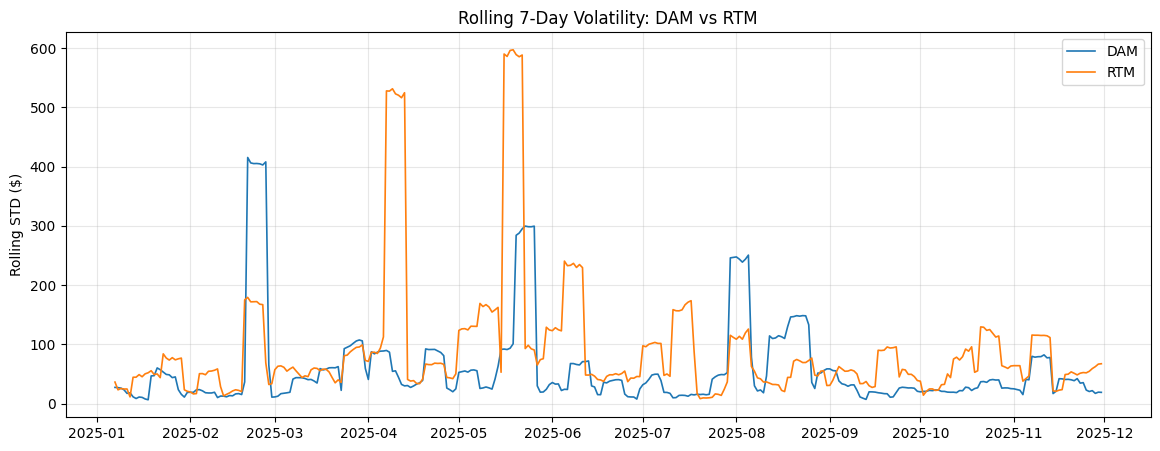

In [67]:
merged['vol_dam'] = merged['dam_revenue'].rolling(7).std()
merged['vol_rtm'] = merged['rtm_revenue'].rolling(7).std()

plt.figure(figsize=(14,5))
plt.plot(merged['date'], merged['vol_dam'], label="DAM", lw=1.2)
plt.plot(merged['date'], merged['vol_rtm'], label="RTM", lw=1.2)
plt.title("Rolling 7-Day Volatility: DAM vs RTM")
plt.ylabel("Rolling STD ($)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [68]:
from scipy.optimize import linprog

def dam_lp_optimum_day(prices, P_MAX=1.0, E_MAX=2.0, RTE=0.85):

    prices = np.array(prices, dtype=float)
    T = len(prices)
    if T != 24:
        raise ValueError(f"Expected 24 hourly DAM prices, got {T}")

    n_c, n_d, n_soc = T, T, T + 1
    n_vars = n_c + n_d + n_soc

    def idx_c(t):   return t
    def idx_d(t):   return n_c + t
    def idx_soc(t): return n_c + n_d + t

    c_obj = np.zeros(n_vars)
    for t in range(T):
        c_obj[idx_c(t)] = +prices[t]        
        c_obj[idx_d(t)] = -prices[t] * RTE  

    A_eq = []
    b_eq = []

    for t in range(T):
        row = np.zeros(n_vars)
        row[idx_soc(t+1)] = 1
        row[idx_soc(t)]   = -1
        row[idx_c(t)]     = -1
        row[idx_d(t)]     = +1
        A_eq.append(row)
        b_eq.append(0)

    row0 = np.zeros(n_vars)
    row0[idx_soc(0)] = 1
    A_eq.append(row0)
    b_eq.append(0)

    rowT = np.zeros(n_vars)
    rowT[idx_soc(T)] = 1
    A_eq.append(rowT)
    b_eq.append(0)

    A_eq = np.array(A_eq)
    b_eq = np.array(b_eq)

    bounds = []
    bounds += [(0, P_MAX) for _ in range(T)]     
    bounds += [(0, P_MAX) for _ in range(T)]     
    bounds += [(0, E_MAX) for _ in range(T + 1)] 

    res = linprog(
        c=c_obj,
        A_eq=A_eq,
        b_eq=b_eq,
        bounds=bounds,
        method="highs"
    )

    if not res.success:
        return np.nan
    
    return -res.fun

def run_dam_lp_comparison(dam_excel, HUB, months=None):
    if months is None:
        months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                  "Jul", "Aug", "Sep", "Oct", "Nov"]

    rows = []

    for m in months:
        print(f"Processing LP comparison for DAM {m}...")
        days, daily_arrays = dam_load_and_clean_month(dam_excel, m, HUB)

        for d, prices in zip(days, daily_arrays):
            tg_rev, tg_tau = dam_tau_greedy_day(prices)
            lp_rev = dam_lp_optimum_day(prices, P_MAX=P_MAX, E_MAX=E_MAX, RTE=RTE)

            if lp_rev is None or np.isnan(lp_rev) or lp_rev <= 0:
                capture = np.nan
                gap = np.nan
            else:
                capture = tg_rev / lp_rev
                gap = lp_rev - tg_rev

            rows.append({
                "date": pd.to_datetime(d),
                "month": m,
                "tau_greedy_rev": tg_rev,
                "tau_greedy_tau": tg_tau,
                "lp_opt_rev": lp_rev,
                "capture_ratio": capture,
                "opt_gap": gap
            })

    df = pd.DataFrame(rows).sort_values("date").reset_index(drop=True)
    return df


lp_compare_df = run_dam_lp_comparison(dam_excel=dam_excel, HUB=HUB)
lp_compare_df.head()


Processing LP comparison for DAM Jan...
Processing LP comparison for DAM Feb...
Processing LP comparison for DAM Mar...
Skipping 2025-03-09: 23 hours found
Processing LP comparison for DAM Apr...
Processing LP comparison for DAM May...
Processing LP comparison for DAM Jun...
Processing LP comparison for DAM Jul...
Processing LP comparison for DAM Aug...
Processing LP comparison for DAM Sep...
Processing LP comparison for DAM Oct...
Processing LP comparison for DAM Nov...
Skipping 2025-11-02: 25 hours found


,date,month,tau_greedy_rev,tau_greedy_tau,lp_opt_rev,capture_ratio,opt_gap
0,2025-01-01,Jan,30.0780,16,35.6900,0.842757,5.6120
1,2025-01-02,Jan,28.0710,4,31.7365,0.884502,3.6655
2,2025-01-03,Jan,20.9065,16,39.8330,0.524854,18.9265
3,2025-01-04,Jan,14.7855,14,26.7335,0.553070,11.9480
4,2025-01-05,Jan,39.0105,4,46.6815,0.835674,7.6710


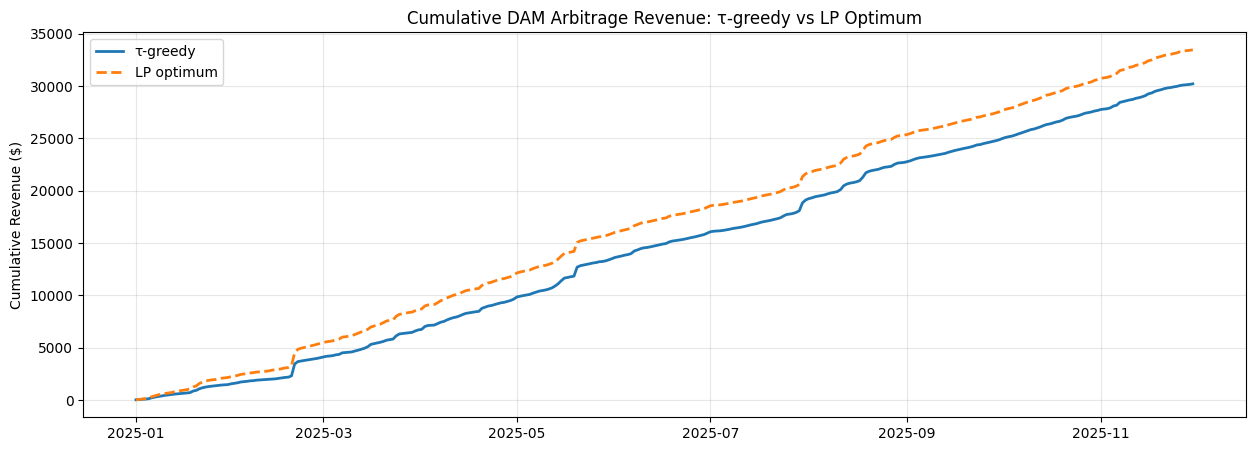

In [69]:
df = lp_compare_df.copy().sort_values("date")

df["cum_tau"] = df["tau_greedy_rev"].cumsum()
df["cum_lp"]  = df["lp_opt_rev"].cumsum()

plt.figure(figsize=(15,5))
plt.plot(df["date"], df["cum_tau"], label="τ-greedy", lw=2)
plt.plot(df["date"], df["cum_lp"], label="LP optimum", lw=2, linestyle="--")

plt.title("Cumulative DAM Arbitrage Revenue: τ-greedy vs LP Optimum")
plt.ylabel("Cumulative Revenue ($)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


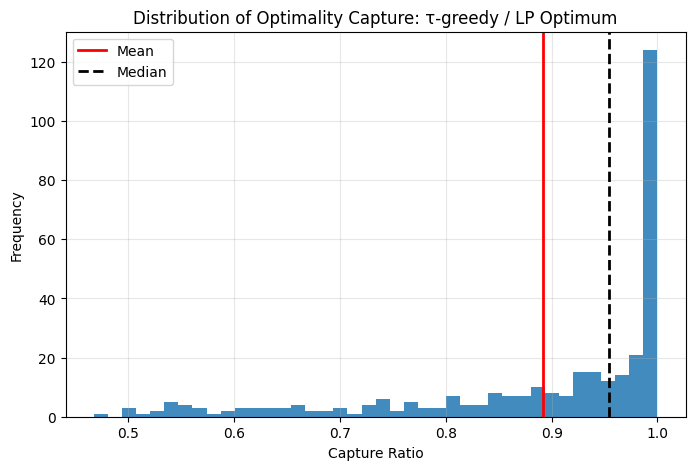

In [70]:
capture = df["capture_ratio"].dropna()

plt.figure(figsize=(8,5))
plt.hist(capture, bins=40, alpha=0.85)

plt.axvline(capture.mean(), color="red", lw=2, label="Mean")
plt.axvline(capture.median(), color="black", lw=2, linestyle="--", label="Median")

plt.title("Distribution of Optimality Capture: τ-greedy / LP Optimum")
plt.xlabel("Capture Ratio")
plt.ylabel("Frequency")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


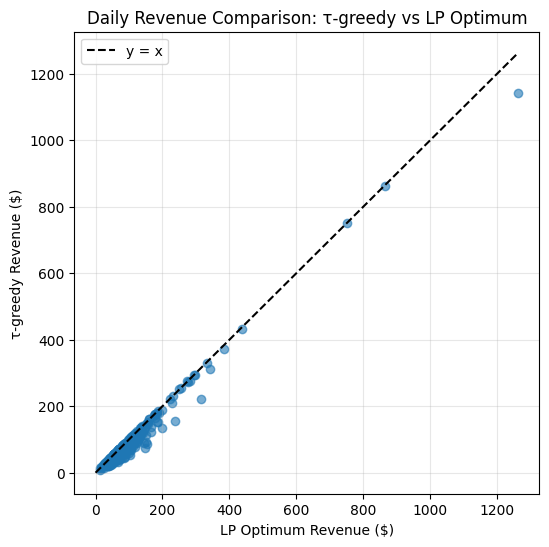

In [71]:
plt.figure(figsize=(6,6))
plt.scatter(df["lp_opt_rev"], df["tau_greedy_rev"], alpha=0.6)

max_val = np.nanmax([df["lp_opt_rev"].max(), df["tau_greedy_rev"].max()])
plt.plot([0, max_val], [0, max_val], linestyle="--", color="black", label="y = x")

plt.xlabel("LP Optimum Revenue ($)")
plt.ylabel("τ-greedy Revenue ($)")
plt.title("Daily Revenue Comparison: τ-greedy vs LP Optimum")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
